### Chris Hamm 2019-09-23 (initial code)
A jupyter notebook to add *Neonympha* images from google images. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [2]:
from fastai import *
from fastai.vision import *

In [3]:
np.random.seed(1138)

Now prepare to download the files to our repo

In [4]:
gimage_path = "../data/images/"

Nar

In [ ]:
# Nar_folder = "Nar"
# Nar_file = "Nar_photos.txt"
# Nar_path = Path('../data/images/Nar')
# Nar_dest = Nar_path/Nar_folder
# Nar_dest.mkdir(parents = True, exist_ok = True)

Nmi

In [ ]:
# Nmi_folder = "Nmi"
# Nmi_file = "Nmi_photos.txt"
# Nmi_path = Path('../data/images/Nmi')
# Nmi_dest = Nmi_path/Nmi_folder
# Nmi_dest.mkdir(parents = True, exist_ok = True)

Nfr

In [ ]:
# Nfr_folder = "Nfr"
# Nfr_file = "Nfr_photos.txt"
# Nfr_path = Path('../data/images/Nfr')
# Nfr_dest = Nfr_path/Nfr_folder
# Nfr_dest.mkdir(parents = True, exist_ok = True)

Nhe

In [ ]:
# Nhe_folder = "Nhe"
# Nhe_file = "Nhe_photos.txt"
# Nhe_path = Path('../data/images/Nhe')
# Nhe_dest = Nhe_path/Nhe_folder
# Nhe_dest.mkdir(parents = True, exist_ok = True)

Download the images

In [5]:
classes = ['Nar', 'Nmi', 'Nfr', 'Nhe']

In [ ]:
#download_images(Nar_path/Nar_file, Nar_dest, max_pics = 50)
#download_images(Nmi_path/Nmi_file, Nmi_dest, max_pics = 50)
#download_images(Nfr_path/Nfr_file, Nfr_dest, max_pics = 50)
#download_images(Nhe_path/Nhe_file, Nhe_dest, max_pics = 50)

Commenting the original code while I mess with the progressive resizing

In [ ]:
# gimage_data = ImageDataBunch.from_folder(path = gimage_path, train = ".", 
#                                          valid_pct = 0.2, ds_tfms = get_transforms(),
#                                         size = 224, num_workers = 4, bs = 64).normalize(imagenet_stats)

In [6]:
transforms = get_transforms(flip_vert = True, max_warp = 0.1, \
                            max_zoom = 1.05, )

In [7]:
data_64 = ImageDataBunch.from_folder(path = gimage_path, train = ".", 
                                         valid_pct = 0.2, ds_tfms = transforms,
                                        size = 64, num_workers = 4, bs = 64).normalize(imagenet_stats)

In [ ]:
data_64

In [ ]:
print(data_64.classes)

In [ ]:
data_64.show_batch(rows = 3, figsize = (6, 6))

### `resnet34`

In [8]:
# with 64 sized images
learn_rn34 = cnn_learner(data_64, \
                            models.resnet34, \
                            metrics = error_rate)

In [9]:
learn_rn34.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


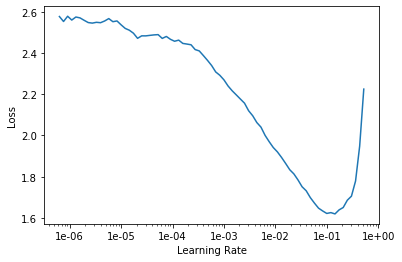

In [10]:
learn_rn34.recorder.plot()

In [11]:
learn_rn34.fit_one_cycle(4, max_lr = slice(1e-03, 1e-02)) 
# with specified LR, get error rate of ~25% after 4 cycles

epoch,train_loss,valid_loss,error_rate,time
0,1.890552,2.397380,0.315789,00:15
1,1.590513,1.301712,0.289474,00:15
2,1.413246,0.961428,0.263158,00:15
3,1.246963,0.815054,0.254386,00:16


In [12]:
learn_rn34.save('stage_1_64_rn34')

#### Tweak learning rate and run some more

In [17]:
learn_rn34.load('stage_1_64_rn34')

Learner(data=ImageDataBunch;

Train: LabelList (458 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
Nar,Nar,Nar,Nar,Nar
Path: ../data/images;

Valid: LabelList (114 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
Nhe,Nmi,Nmi,Nmi,Nhe
Path: ../data/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): Re

In [19]:
learn_rn34.unfreeze()

In [20]:
learn_rn34.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


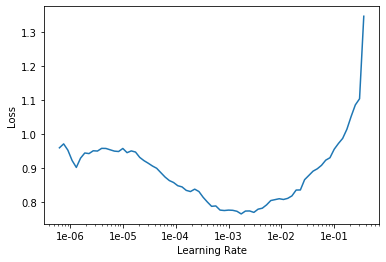

In [21]:
learn_rn34.recorder.plot()

In [27]:
learn_rn34.fit_one_cycle(4, max_lr = slice(1e-05, 5e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.833490,0.653856,0.122807,00:16
1,0.688139,0.568970,0.149123,00:16
2,0.676928,0.602361,0.201754,00:16
3,0.632430,0.574230,0.149123,00:16


In [28]:
learn_rn34.save('stage_2_64_rn34')

### Now the progressive augmentation

In [29]:
data_128 = ImageDataBunch.from_folder(path = gimage_path, \
                                      train = ".", \
                                      valid_pct = 0.2, \
                                      ds_tfms = transforms, \
                                      size = 128, num_workers = 4, \
                                      bs = 64).normalize(imagenet_stats)

In [ ]:
data_128.show_batch(rows = 3, figsize = (6, 6))

In [30]:
learn_rn34.unfreeze()
learn_rn34.data = data_128
learn_rn34.freeze()

In [31]:
learn_rn34.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


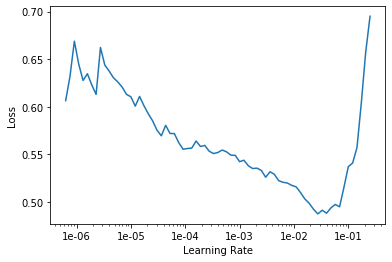

In [32]:
learn_rn34.recorder.plot()

In [33]:
learn_rn34.fit_one_cycle(4, max_lr = slice(1e-05, 1e-02))

epoch,train_loss,valid_loss,error_rate,time
0,0.632488,0.506873,0.131579,00:16
1,0.567752,0.470198,0.122807,00:16
2,0.538100,0.497768,0.131579,00:15
3,0.504526,0.458895,0.114035,00:15


In [34]:
learn_rn34.save('stage_3_128_rn34')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


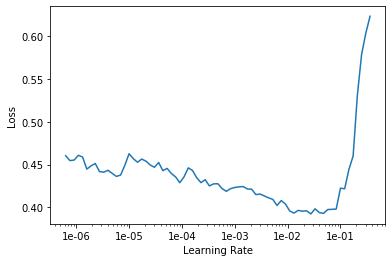

In [35]:
learn_rn34.lr_find()

learn_rn34.recorder.plot()

In [36]:
learn_rn34.unfreeze()

In [39]:
learn_rn34.fit_one_cycle(4, max_lr = slice(1e-05, 1e-02)) 

epoch,train_loss,valid_loss,error_rate,time
0,0.479503,0.718665,0.175439,00:15
1,0.483938,1.639340,0.263158,00:15
2,0.468940,0.958016,0.166667,00:16
3,0.417884,0.498607,0.175439,00:15


In [40]:
learn_rn34.save('stage_4_128_rn34')

#### 256 images

In [41]:
data_256 = ImageDataBunch.from_folder(path = gimage_path, \
                                      train = ".", \
                                      valid_pct = 0.2, \
                                      ds_tfms = transforms, \
                                      size = 256, num_workers = 4, \
                                      bs = 32).normalize(imagenet_stats)

In [42]:
learn_rn34.unfreeze()
learn_rn34.data = data_256
learn_rn34.freeze()

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fd06de30b38>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/opt/conda/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


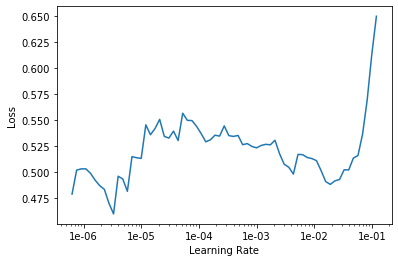

In [43]:
learn_rn34.lr_find()

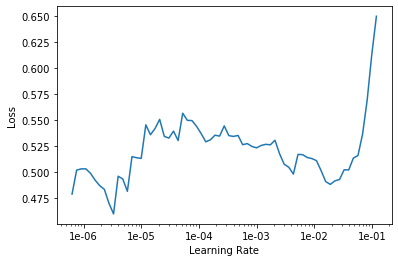

In [44]:
learn_rn34.recorder.plot()

In [45]:
learn_rn34.fit_one_cycle(4, max_lr = slice(1e-04, 1e-02))

epoch,train_loss,valid_loss,error_rate,time
0,0.477029,0.367196,0.140351,00:16
1,0.487905,0.272037,0.096491,00:15
2,0.432000,0.303157,0.157895,00:15
3,0.408949,0.334070,0.166667,00:15


In [46]:
learn_rn34.save('stage_5_256_rn34')

#### Examine problem areas

In [ ]:
# It is OK for train loss to be lower than valid loss. That is what you want.
# As long as you are training and error is improving you are not overfitting.

In [48]:
interpretation_34 = ClassificationInterpretation.from_learner(learn_rn34)

losses_34, idxs_34 = interpretation_34.top_losses()

len(data_256.valid_ds) == len(losses_34) == len(idxs_34)

True

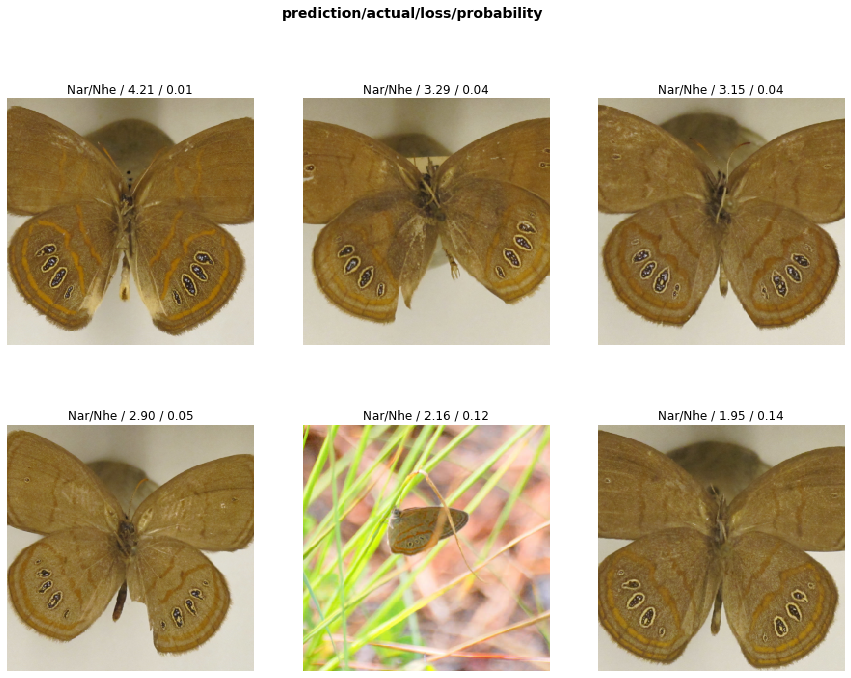

In [49]:
interpretation_34.plot_top_losses(6, figsize = (15, 11))

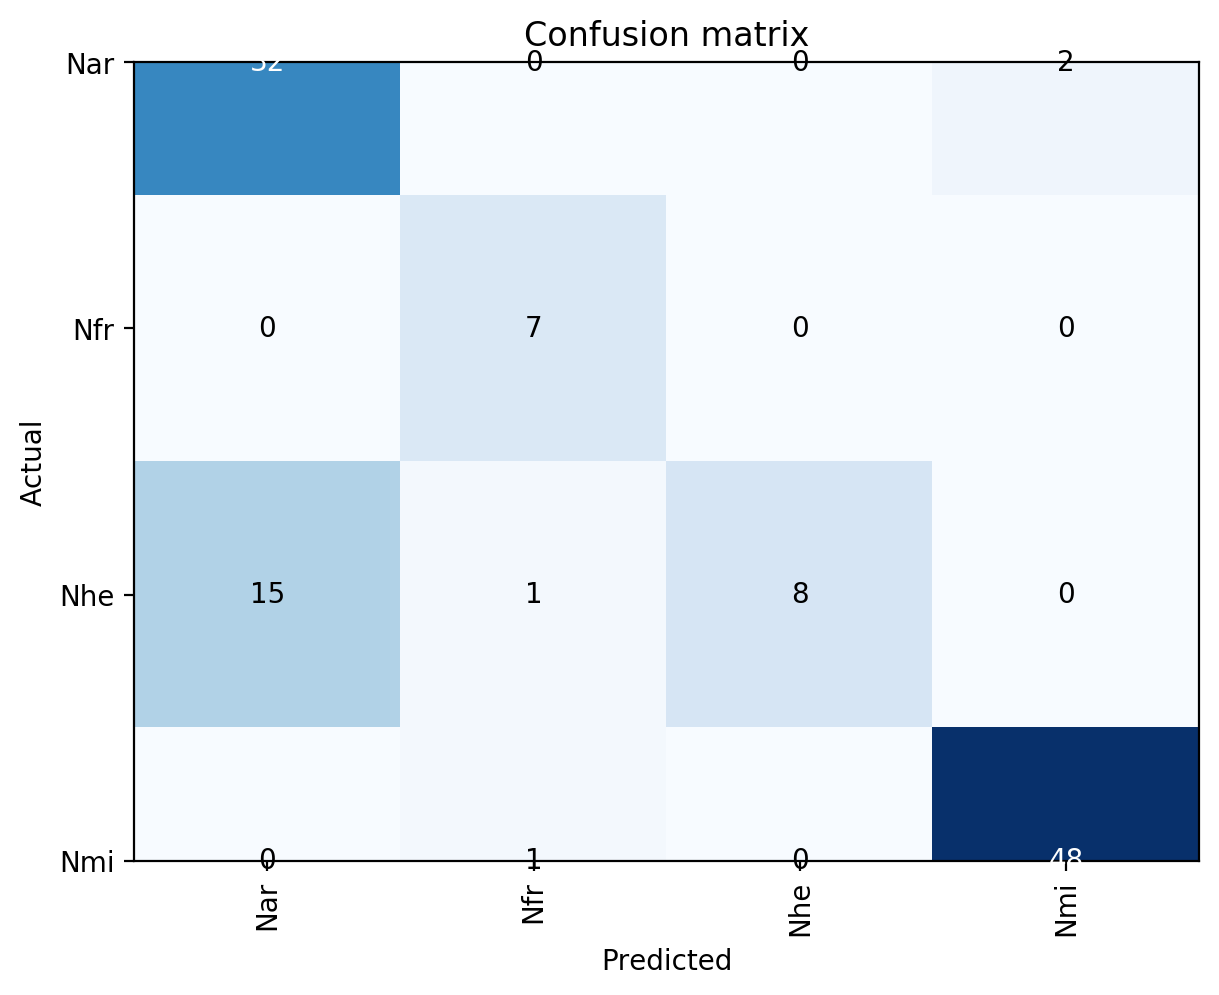

In [50]:
interpretation_34.plot_confusion_matrix(figsize = (6, 6), dpi = 200)

In [51]:
interpretation_34.most_confused(min_val = 0) 

[('Nhe', 'Nar', 15),
 ('Nar', 'Nmi', 2),
 ('Nhe', 'Nfr', 1),
 ('Nmi', 'Nfr', 1),
 ('Nar', 'Nar', 0),
 ('Nar', 'Nfr', 0),
 ('Nar', 'Nhe', 0),
 ('Nfr', 'Nar', 0),
 ('Nfr', 'Nfr', 0),
 ('Nfr', 'Nhe', 0),
 ('Nfr', 'Nmi', 0),
 ('Nhe', 'Nhe', 0),
 ('Nhe', 'Nmi', 0),
 ('Nmi', 'Nar', 0),
 ('Nmi', 'Nhe', 0),
 ('Nmi', 'Nmi', 0)]

### `resnet50`

In [ ]:
gimage_learn50 = cnn_learner(gimage_data, models.resnet50, metrics = error_rate)

In [ ]:
gimage_learn50.fit_one_cycle(4) # 7% error after 4 cycles

In [ ]:
ginterpretation50 = ClassificationInterpretation.from_learner(gimage_learn50)

glosses50, gidxs50 = ginterpretation50.top_losses()

len(gimage_data.valid_ds) == len(glosses50) == len(gidxs50)

In [ ]:
ginterpretation50.plot_top_losses(6, figsize = (15, 11))

In [ ]:
ginterpretation50.most_confused(min_val = 0) 

### Trying larger images

In [ ]:
gimage_data2 = ImageDataBunch.from_folder(path = gimage_path, train = ".", 
                                         valid_pct = 0.25, ds_tfms = get_transforms(),
                                        size = 294, num_workers = 4, bs = 16).normalize(imagenet_stats)

In [ ]:
gimage_learn50b = cnn_learner(gimage_data2, models.resnet50, metrics = error_rate)

In [ ]:
gimage_learn50b.fit_one_cycle(4) # after 4 cycles error is 9%
# increasing the image size to 350 does not improve error

Larger images still

In [ ]:
gimage_data3 = ImageDataBunch.from_folder(path = gimage_path, train = ".", 
                                         valid_pct = 0.25, ds_tfms = get_transforms(),
                                        size = 350, num_workers = 4, bs = 8).normalize(imagenet_stats)

In [ ]:
gimage_learn50c = cnn_learner(gimage_data3, models.resnet50, metrics = error_rate)

In [ ]:
gimage_learn50c.fit_one_cycle(6) # after 4 cycles error is